In [2]:
# 載入常用套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# os.chdir('./dataset/textmining') # 設定環境目錄

# PTT 版內容分析

## 文字前處理

### 1. 爬蟲

In [4]:
import requests
from bs4 import BeautifulSoup
import time
# 依照時間允許做網頁的取出
titleList = []
# 這邊先取100筆 在soft_job版跟python有關的標題
for i in range(1,6):
    URL = "https://www.ptt.cc/bbs/Soft_Job/search?page="+str(i)+"&q=python"
    my_headers = {'cookie': 'over18=1;'}
    response = requests.get(URL, headers = my_headers)
    soup = BeautifulSoup(response.text, "html.parser")
    titles = soup.find_all("div",class_="title")
    for title in titles:
        titleList.append(title.select_one("a").get("href"))
    time.sleep(0.5)
# 檢查用，確認爬蟲結果
i = 0
for title in titleList:
    i += 1
    print(title)
print(i)

/bbs/Soft_Job/M.1642687518.A.058.html
/bbs/Soft_Job/M.1642664945.A.E4C.html
/bbs/Soft_Job/M.1642569109.A.8E2.html
/bbs/Soft_Job/M.1634895257.A.756.html
/bbs/Soft_Job/M.1629382738.A.F71.html
/bbs/Soft_Job/M.1629343265.A.044.html
/bbs/Soft_Job/M.1628781494.A.6E7.html
/bbs/Soft_Job/M.1628748218.A.0D6.html
/bbs/Soft_Job/M.1628582877.A.FD9.html
/bbs/Soft_Job/M.1628564211.A.AC8.html
/bbs/Soft_Job/M.1628504776.A.546.html
/bbs/Soft_Job/M.1627993292.A.ED5.html
/bbs/Soft_Job/M.1627032495.A.65E.html
/bbs/Soft_Job/M.1626915488.A.94A.html
/bbs/Soft_Job/M.1625583829.A.47D.html
/bbs/Soft_Job/M.1618987656.A.84C.html
/bbs/Soft_Job/M.1618739976.A.571.html
/bbs/Soft_Job/M.1617036936.A.230.html
/bbs/Soft_Job/M.1616864612.A.F96.html
/bbs/Soft_Job/M.1616862026.A.F6D.html
/bbs/Soft_Job/M.1616854807.A.2F3.html
/bbs/Soft_Job/M.1616832576.A.DCB.html
/bbs/Soft_Job/M.1616754376.A.CA6.html
/bbs/Soft_Job/M.1614829320.A.108.html
/bbs/Soft_Job/M.1611835949.A.2D3.html
/bbs/Soft_Job/M.1610997557.A.9E9.html
/bbs/Soft_Jo

In [5]:
# 透過爬蟲將內文取出，做稍後的文字分析(可參考5-4的爬蟲程式碼)
ptt = "https://www.ptt.cc"
contentList = []
for i in range(len(titleList)):
    URL = ptt + titleList[i]
    my_header = {'cookie': 'over18=1;'}
    response = requests.get(URL, headers = my_header)
    soup = BeautifulSoup(response.text, "html.parser")
    content = soup.find("div",class_="bbs-screen bbs-content").getText()
    content = content.split("--")[0]
    content = content.split("\n")
    content = content[1:]
    content = "\n".join(content)
    contentList.append(content)
    time.sleep(0.1)

In [7]:
for i in range(10):
    print(content[i])

※
 
引
述
《
r
e
g
m
e


### 2. 使用NLP套件進行中文斷詞

In [6]:
# 下載中文NLP套件
!pip install ckiptagger[tf,gdown]
# 下載ckiptagger所需的文件檔案用以做文字分析
# 套件會自動下載到 ./data.zip (2GB) 資料夾並且從中讀取所需檔案
data_utils.download_data_gdown("./")

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4847 sha256=856f797ccc62c44fd399d07f525d2bc590ae61f1416787ed37abc2893bf1af97
  Stored in directory: c:\users\rebca\appdata\local\pip\cache\wheels\b6\0d\90\0d1bbd99855f99cb2f6c2e5ff96f8023fad8ec367695f7d72d
  Created wheel for gdown: filename=gdown-4.2.0-py3-none-any.whl size=14262 sha256=743492b921095a94efae955d05e5f77d83d8ef13058bb43d215e7f02ed777291
  Stored in directory: c:\users\rebca\appdata\local\pip\cache\wheels\68\11\97\886e5796b655bf28bf4a0d75e933ea71c6d7d34be701168d1d
Successfully built termcolor gdown


NameError: name 'data_utils' is not defined

ws 其他可用參數：
+ sentence_segmentation = True (考慮分隔符號)
+ segment_delimiter_set = {",", "。", ":", "?", "!", ";"}) (默認的分隔符號)
+ recommend_dictionary = dictionary1 (優先斷詞)
+ coerce_dictionary = dictionary2 (強制斷詞)

In [ ]:
# import所需使用的套件
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER

# 呼叫上面所下載的NLP包用以做POS和NER
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

# 初始化
NERList = []

# 這邊以PTT其中的一段新聞稿為例
sentence_list = ["台鐵太魯閣號事故造成49人罹難、218人受傷，衛福部隨即在3日宣布設立賑災專戶開放民眾捐款，截至昨天為止已募得8.1億元。",
                 "衛福部今傍晚召開第一次管理及監督委員會，確認捐款將有7項用途，包括對受災民眾或家屬經濟支持、醫療補助、教育資助、心理重建、法律扶助、遺屬關懷重建以及經委員會專案同意項目，但各項具體金額今則未討論。",
                 "會議召集人、衛福部次長李麗芬說，會議共識捐款總金額給予罹難者的扶助金不會低於總捐款1/3。",
                 "依現行募得款項推估，至少會有2.7億元用於此項用途。"]
# 幫上述例子做斷詞
word_sentence_list = ws(sentence_list)

查看部分斷詞完的結果：

In [ ]:
word_sentence_list[0][:5]

['台鐵', '太魯閣號', '事故', '造成', '49']

### 3. POS & NER 分析

In [ ]:
def print_word_pos_sentence(word_sentence, pos_sentence):
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence):
        print(f"{word}({pos})", end="\u3000") # \u3000代表空白格，print ()的結尾默認為新的一行’\n’，透過end參數設定可以有不一樣的呈現。
    print()
    return

In [ ]:
# 做詞性標記(POS)
pos_sentence_list = pos(word_sentence_list)
# 做實體辨識(NER)
entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

In [ ]:
# 將三者組合後印出
for i, sentence in enumerate(sentence_list):
    print()
    print(f"'{sentence}'")
    print_word_pos_sentence(word_sentence_list[i],  pos_sentence_list[i])
    for entity in sorted(entity_sentence_list[i]):
        print(entity)


'台鐵太魯閣號事故造成49人罹難、218人受傷，衛福部隨即在3日宣布設立賑災專戶開放民眾捐款，截至昨天為止已募得8.1億元。'
台鐵(Nc)　太魯閣號(Nb)　事故(Na)　造成(VK)　49(Neu)　人(Na)　罹難(VH)　、(PAUSECATEGORY)　218(Neu)　人(Na)　受傷(VH)　，(COMMACATEGORY)　衛福部(Nc)　隨即(D)　在(P)　3日(Nd)　宣布(VE)　設立(VC)　賑災(VA)　專戶(Na)　開放(VC)　民眾(Na)　捐款(VB)　，(COMMACATEGORY)　截至(P)　昨天(Nd)　為止(Ng)　已(D)　募得(VJ)　8.1億(Neu)　元(Nf)　。(PERIODCATEGORY)　
(0, 2, 'ORG', '台鐵')
(10, 12, 'CARDINAL', '49')
(16, 19, 'CARDINAL', '218')
(23, 26, 'ORG', '衛福部')
(29, 31, 'DATE', '3日')
(48, 50, 'DATE', '昨天')
(55, 60, 'MONEY', '8.1億元')

'衛福部今傍晚召開第一次管理及監督委員會，確認捐款將有7項用途，包括對受災民眾或家屬經濟支持、醫療補助、教育資助、心理重建、法律扶助、遺屬關懷重建以及經委員會專案同意項目，但各項具體金額今則未討論。'
衛福部(Nc)　今(Nd)　傍晚(Nd)　召開(VC)　第一(Neu)　次(Nf)　管理(VC)　及(Caa)　監督(VC)　委員會(Nc)　，(COMMACATEGORY)　確認(VE)　捐款(VB)　將(D)　有(V_2)　7(Neu)　項(Nf)　用途(Na)　，(COMMACATEGORY)　包括(VK)　對(P)　受(VJ)　災(Na)　民眾(Na)　或(Caa)　家屬(Na)　經濟(Na)　支持(VC)　、(PAUSECATEGORY)　醫療(VC)　補助(VD)　、(PAUSECATEGORY)　教育(Na)　資助(VC)　、(PAUSECATEGORY)　心理(Na)　重建(VC)　、(PAUSECATEGORY)　法律(Na)　扶助(VC)　、(PAUSECATEGORY)　遺屬(Na)　關懷(VJ)　重建(VC)　以及(Caa)　經(P)　委員會(Nc)　專案(

#### 以長條圖視覺化

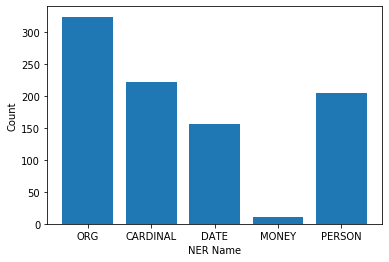

In [ ]:
# 初始化設定
org = 0
cardinal = 0
date = 0
money = 0
person = 0
EntityList= []

for content in contentList: # 使用爬蟲的資料(80篇)
    sentence_list = [content]
    word_sentence_list = ws(sentence_list) # 斷詞
    pos_sentence_list = pos(word_sentence_list) # POS
    entity_sentence_list = ner(word_sentence_list, pos_sentence_list) # NER
    # 透過迴圈將NER取出，並針對五項實體(Entity)統計頻率
    for i, sentence in enumerate(sentence_list): 
        for entity in sorted(entity_sentence_list[i]):
            # 將每項種類數量計算出來
            org = entity.count('ORG') + org
            cardinal = entity.count('CARDINAL') + cardinal
            date =  entity.count('DATE') + date
            money = entity.count('MONEY') + money
            person = entity.count('PERSON') + person
            EntityList.append(entity[3])

# 視覺化
x = ['ORG','CARDINAL','DATE','MONEY','PERSON']            
y = [org, cardinal, date, money, person]
plt.xlabel('NER Name')
plt.ylabel('Count')
plt.bar(x,y)
plt.show()

#### 以文字雲視覺化呈現NER的字詞

In [ ]:
# 下載套件
# !pip install wordcloud

In [ ]:
# 計算各個實體各自出現的次數
def calculateTime(List):
    dic = {}
    count = 0
    word = ""
    NewList = []
    NewList2 = []
    for i in range(len(List)):
        word = List[i]
        for j in range(len(List)):
            if List[i] == List[j]:
                count += 1      
        # 取出次數超過10次的NER
        if count > 10:
            if NewList.count(str(count) + "個" + word) == 0:
                NewList.append(str(count) + "個" + word)
                dic[word] = count
        count = 0
        word = ""    
    return NewList, dic

In [ ]:
# 查看詞頻統計
NewList, dic = calculateTime(EntityList)
print(NewList)

['44個臺鐵', '40個一', '11個第一', '23個台灣', '13個兩', '92個台鐵', '34個405', '14個台東', '11個樹林', '15個王', '13個太魯閣', '11個台鐵局', '22個今天', '24個49', '11個武塔站', '11個13', '11個民進黨', '16個蘇貞昌', '27個王國材', '17個交通部', '12個台灣人', '13個三天', '15個1500萬', '12個李義祥', '12個王薇君', '20個林佳龍', '12個陳明文']


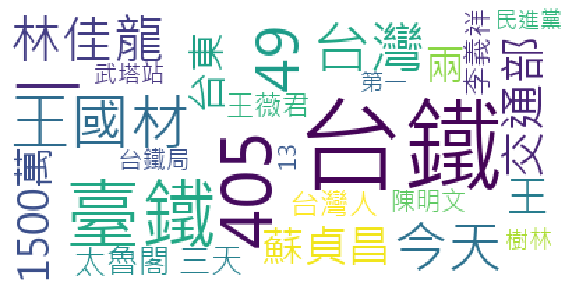

In [ ]:
from wordcloud import WordCloud

# 將上述詞頻放入wordcloud畫圖
# wordcloud的內建字體無法將中文顯示，需要指定電腦中的中文字體路徑，這邊使用微軟正黑體示範
font = '/Users/ritatang/Library/Fonts/msjh.ttf' # 若是Windows電腦，參考路徑為："C:\Windows\Fonts\msjh.ttc"
wordcloud = WordCloud(background_color = "white",font_path = font)
wordcloud.generate_from_frequencies(dic) # 指定以word出現的頻率來畫大小

# 設定大小，以及讓文字雲顯示
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## 6-2-2: 字詞統計 (TF-IDF)

### 1. 文字前處理

+ 停用字字典來源：https://github.com/goto456/stopwords 。

In [ ]:
# 初始化
word_list = []
word_list2 = []
stopwords_list = [] 

# 斷詞
words_list = ws(contentList) # 使用爬蟲的資料(80篇)

# 設定停用字
stop = open("stopwords.txt", encoding='utf-8').readlines() # 匯入停用字字典 
for i in range(len(stop)):
    stop[i] = stop[i].replace('\n','')
    stopwords_list.append(stop[i])

for j in range(len(words_list)):
    word_list = [] # 每篇開始前要先清空
    for i in words_list[j]:
        if i not in stopwords_list: # 排除停用字
            word_list.append(i)
            if word_list not in word_list2:
                word_list2.append(word_list) # 最終使用word_list2

### 2. 計算tf-idf

tf：

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()  
for i in word_list2:
    X = vectorizer.fit_transform(i)

tf = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
tf = tf.stack().reset_index() # 轉換dataframe格式
tf.columns = ['article','word','tf']
tf.head()

,article,word,tf
0,0,12,0
1,0,16,0
2,0,17,0
3,0,2021,0
4,0,44,0


idf：

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=False, smooth_idf=True, norm=None)  
for i in word_list2:
    X = vectorizer.fit_transform(i)

idf = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
idf = vectorizer.idf_
idf = pd.DataFrame([vectorizer.idf_], columns=vectorizer.get_feature_names())
idf = idf.stack().reset_index().iloc[:,[1,2]] # 轉換dataframe格式
idf.columns = ['word','idf']
idf.head()

,word,idf
0,12,4.998201
1,16,4.998201
2,17,4.998201
3,2021,4.998201
4,44,4.998201


tf-idf：

In [ ]:
df = pd.merge(tf, idf, on='word', how='left') # 合併前面的結果
df['tf-idf'] = df['tf']*df['idf']
df.sort_values(by='tf-idf', ascending=False)

,article,word,tf,idf,tf-idf
1780,38,時間,1,4.998201,4.998201
3656,79,外勞,1,4.998201,4.998201
1801,39,apr,1,4.998201,4.998201
1803,39,sat,1,4.998201,4.998201
1936,42,44,1,4.998201,4.998201
...,...,...,...,...,...
1662,36,49,0,4.998201,0.000000
1661,36,484,0,4.592736,0.000000
1660,36,44,0,4.998201,0.000000
1659,36,2021,0,4.998201,0.000000


In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

# 透過sklearn計算tf-idf的score
transformer = TfidfTransformer(smooth_idf=True)
Z = transformer.fit_transform(X)

tfidf = pd.DataFrame(Z.toarray(),columns=vectorizer.get_feature_names())
tfidf = tfidf.stack().reset_index() # 轉換dataframe格式
tfidf.columns = ['article','word','score']
tfidf.sort_values(by='score', ascending=False)

,article,word,score
378,8,中國,1.0
1842,40,17,1.0
4812,104,悲哀,1.0
4521,98,五十,1.0
2458,53,台灣人,1.0
...,...,...,...
1662,36,49,0.0
1661,36,484,0.0
1660,36,44,0.0
1659,36,2021,0.0


tf-idf有很多種變形，可以看到sklearn計算的tf-idf分數與我們透過理論相乘的結果有些差距，是因為sklearn在計算時會先做標準化的動作(並非常用見的tf-idf)。<br>
因此這裡我們做了兩種版本給大家參考。

## 6-2-3: 主題分析 (LDA)

In [ ]:
# 下載套件
# !pip install jieba           # 斷詞用
# !pip install gensim          # LDA建模用
# !pip install pyLDAvis==2.1.2 # LDA視覺化用

### 1. 計算LDA

In [ ]:
from gensim import corpora, models
import jieba.posseg as jp, jieba

# 斷詞跟排除停用字
words_list = []
for text in contentList: # 使用爬蟲的資料(80篇)
    text = text.replace('\n','')
    text = text.replace(' ','')
    words = [w.word for w in jp.cut(text) if w.word not in stopwords_list]
    words_list.append(words)

# 進行LDA
dic = corpora.Dictionary(words_list) # 構建辭典
corpus = [dic.doc2bow(words) for words in words_list] # 形成向量集
lda = models.ldamodel.LdaModel(corpus = corpus, id2word = dic, num_topics = 3) # 設置lda主題個數

# 將各主題的詞彙取出
for topic in lda.print_topics(num_words = 5):
    print(topic)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/dt/brfqfqpx2nx6x96txdg151hh0000gn/T/jieba.cache
Loading model cost 0.775 seconds.
Prefix dict has been built successfully.
(0, '0.009*"後" + 0.009*"廠商" + 0.009*"工程" + 0.009*"施工" + 0.009*"台鐵"')
(1, '0.009*"台鐵" + 0.008*"太魯閣" + 0.008*"人" + 0.007*"廠商" + 0.007*"新聞"')
(2, '0.009*"太魯閣" + 0.009*"廠商" + 0.008*"人" + 0.008*"工程" + 0.008*"後"')


### 2. LDA視覺化

In [ ]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary=lda.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.015986 -0.000666       1        1  51.336855
2     -0.008945 -0.008065       2        1  25.615785
0     -0.007042  0.008732       3        1  23.047360, topic_info=    Term        Freq       Total Category  logprob  loglift
113   工程   91.000000   91.000000  Default  30.0000  30.0000
152   施工   95.000000   95.000000  Default  29.0000  29.0000
119   廠商  112.000000  112.000000  Default  28.0000  28.0000
123    後  106.000000  106.000000  Default  27.0000  27.0000
392   工人   76.000000   76.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
247    號   13.182329   85.422129   Topic3  -5.4877  -0.4011
30    事故    9.980232   50.541191   Topic3  -5.7659  -0.1546
595   完整   11.055899   63.134526   Topic3  -5.6636  -0.2747
405    撞    9.268957   50.330631   Topic3  -5.8399  -0.2243
33    人員    8.944469   42.540808   Topic3  -5.8755  -0.0918

[261 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1         1  0.736806    .....
1         2  0.184201    .....
1         3  0.184201    .....
493       3  0.654666     4508
1188      1  0.676624  B1lFtWF
...     ...       ...      ...
1601      3  0.141217       關心
1127      2  0.650319       電現
2823      2  0.654873        需
2673      1  0.432489        駕
2673      2  0.432489        駕

[421 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

以瀏覽器打開查看(彈出網頁)：

In [ ]:
pyLDAvis.show(vis) # 需要在自己的電腦上重新run一遍才會看到


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]
127.0.0.1 - - [26/Apr/2021 17:18:14] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/Apr/2021 17:18:14] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [26/Apr/2021 17:18:15] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [26/Apr/2021 17:18:15] "GET /LDAvis.js HTTP/1.1" 200 -

stopping Server...


可以將結果儲存成html檔案：

In [ ]:
# pyLDAvis.save_html(vis, 'lda.html')

## 6-2-4: 情緒分析 (Sentiment Analysis)

### 使用情感分析套件分析

In [ ]:
# !pip install snownlp

In [ ]:
# 情感分析
from snownlp import SnowNLP
from snownlp import sentiment
import pylab as pl

sentence = []
senti_score = []

for j in contentList: # 使用爬蟲的資料(80篇)
    j = j.replace('\n','')
    s = SnowNLP(j)
    sentence.append(j)
    senti_score.append(round(s.sentiments,5))

table = pd.DataFrame({'sentence' : sentence,'score' : senti_score})
table = table.sort_values(by=['score'],ascending=False)
table

,sentence,score
6,可是這是廠商不重視工安造成的結果這次太魯閣出軌後的敏感時機 又出事上新聞結果現在靶子畫在台鐵...,1.00000
9,1.媒體來源:三立新聞2.記者署名:黎冠志3.完整新聞標題:震怒！太魯閣號擦撞闖軌道工人 總...,0.99999
44,其實大約在 4/7 就有看到臉書的一篇就法律層面解釋http://imgur.com/mk8...,0.99912
26,※ 引述《WuSam (藤原豆海)》之銘言：: 405次太魯閣號行經宜蘭武塔站時，: 撞上擅...,0.99901
12,如題之前網路看到牛被火車撞死的影片https://youtu.be/GslGPXFanos影...,0.99767
...,...,...
47,那些善款是民眾的愛心，就是要捐給所有家屬的...照理說所有家屬的連署應該有權利決定善款流向。...,0.00000
50,事實上 這件事 黨的操作就是厲害媒體配合和風向操作 黨就是屌看看一開始的 要救災別咎責檢討的...,0.00000
52,本56是覺得拉這次政府真的做得很不錯了人家都給了1500萬當作交代這已經要千恩萬謝再在那邊說...,0.00000
53,騙神明仔 普悠瑪號檢討報告沒處理一句話不講 悶不吭聲以為人民會就此忘記犯錯的部署官員還能繼續...,0.00000


#### 使用長條圖視覺化

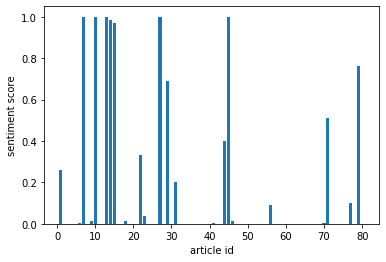

In [ ]:
x = []
for i in range(1,81):
    x.append(i)
y = senti_score
plt.bar(x,y)
plt.ylabel('sentiment score')
plt.xlabel('article id')
plt.show()

分數介於0~1之間，愈高表示愈正向，愈低則是愈負面。